<font size="6">Timeseries Extraction</font>
 
 <font size="3">To demonstrate timeseries extraction using the `TimeseriesExtractor` class, the single subject dataset used to test the neurocaps package will be downloaded for demonstration. For the timeseries extraction to work, the pybids package must be installed. To install pybids on Windows, you can use `pip install pybids`
 or `pip install neurocaps[windows]`. Additionally, for pybids installation on Windows, you may need to enable long path support. The instructions to do so, involves right clicking on Powershell, selecting "Run as Administrator", and pasting in the Powershell command located in the official [Microsoft documentation](https://learn.microsoft.com/en-us/windows/win32/fileio/maximum-file-path-limitation?tabs=powershell). An alternative involves installing [Windows Subsytem for Linux (WSL)](https://code.visualstudio.com/docs/remote/wsl-tutorial) and [opening jupyter notebook from the Ubuntu terminal](https://saturncloud.io/blog/how-to-install-jupyter-notebook-in-ubuntu/). </font>

In [1]:
import os, subprocess, sys
import plotly.io as pio
from neurocaps.extraction import TimeseriesExtractor
from neurocaps.analysis import CAP, merge_dicts, standardize, change_dtype
import numpy as np, joblib

# To show static plotly images so that they can be displayed on the saved Jupyter notebook on Github
pio.renderers.default = "svg"

# Can use atlases in Schaefer and AAL; however, AAL may produce Nan values in this demonstration
parcel_approach = {"Schaefer": {"n_rois": 100}}
# parcel_approach = {"AAL": {"version": "SPM12"}}

ncol = (
    parcel_approach["Schaefer"]["n_rois"]
    if "Schaefer" in parcel_approach.keys()
    else (116 if parcel_approach["AAL"]["version"] != "3v2" else 166)
)

neurocaps_demo_dir = "neurocaps_demo"

os.makedirs(neurocaps_demo_dir, exist_ok=True)

if sys.platform != "win32":
    cmd = """
        cd neurocaps_demo
        git clone --depth 1 --filter=blob:none --sparse https://github.com/donishadsmith/neurocaps.git
        cd neurocaps
        git sparse-checkout set tests/ds000031_R1.0.4_ses001-022
        """
    os.system(cmd)
else:
    neurocaps_repo_dir = os.path.join(neurocaps_demo_dir, "neurocaps")

    # Enable git longpath
    subprocess.run(
        ["git", "config", "--global", "core.longpaths", "true"],
        check=True,
    )

    subprocess.run(
        [
            "git",
            "clone",
            "--depth",
            "1",
            "--filter=blob:none",
            "--sparse",
            "https://github.com/donishadsmith/neurocaps.git",
        ],
        check=True,
        cwd=neurocaps_demo_dir,
    )

    subprocess.run(
        ["git", "sparse-checkout", "set", "tests/ds000031_R1.0.4_ses001-022"],
        check=True,
        cwd=neurocaps_repo_dir,
    )

bids_dir = "neurocaps_demo/neurocaps/tests/ds000031_R1.0.4_ses001-022/ds000031_R1.0.4"

# If there are multiple pipelines in derivatives folder or the pipeline is nested, then pipeline_name should be used
pipeline_name = "fmriprep_1.0.0/fmriprep"

# Adding an asterisk results in all columns starting with name preceding the asterisk to be extracted for nuisance regression
confounds = ["Cosine*", "aComp*", "Rot*"]

# Set up signal cleaning parameters
extractor = TimeseriesExtractor(
    space="MNI152NLin2009cAsym",
    parcel_approach=parcel_approach,
    standardize=False,
    use_confounds=True,
    detrend=True,
    low_pass=0.15,
    confound_names=confounds,
    dummy_scans={"auto": True, "min": 3, "max": 6},
    fd_threshold={"threshold": 0.35, "outlier_percentage": 0.30},
)

# Perform the timeseries extraction; only one session can be extracted at a time. Internally, @cache (or @lru_cache in
# > 18.3) is used so that pybids only needs to be query once for every unique `bids_dir` and `pipeline_name`
# combination per session. ``TimeseriesExtractor.get_bold().clear()`` (or ``TimeseriesExtractor._call_layout.cache_clear()``
# in > 18.3) can be used to clear the cache. Use `n_cores` to speed up extraction
extractor.get_bold(
    bids_dir=bids_dir,
    session="002",
    runs="001",
    task="rest",
    pipeline_name=pipeline_name,
    n_cores=None,
    flush=False,
    tr=1.2,
    verbose=True,
    progress_bar=True,  # Parameter available in versions >= 0.21.5
)

# Standardize after removal of the outlier volumes; extracted timeseries of all subjects in ``extractor.subject_timeseries``
subject_timeseries_dict = standardize(subject_timeseries_list=[extractor.subject_timeseries], return_dicts=True)

# Increase or decrease the dtype; recommend not going lower than float32; this function is intended to decrease `subject_timeseries`
# from float64 to float32 for memory saving purposes while maintaining precision.
subject_timeseries_dict = change_dtype(subject_timeseries_list=[subject_timeseries_dict["dict_0"]], dtype="float32")

# extractor.subject_timeseries is also a setter
extractor.subject_timeseries = subject_timeseries_dict["dict_0"]

2025-02-11 15:30:47,720 neurocaps._utils.check_parcel_approach [WARNING] 'yeo_networks' not specified in `parcel_approach`. Defaulting to 7 networks.
2025-02-11 15:30:47,721 neurocaps._utils.check_parcel_approach [WARNING] 'resolution_mm' not specified in `parcel_approach`. Defaulting to 1mm.
2025-02-11 15:30:47,741 neurocaps._utils.extraction.check_confound_names [INFO] Confound regressors to be used if available: Cosine*, aComp*, Rot*.
2025-02-11 15:30:50,230 neurocaps.extraction.timeseriesextractor [INFO] BIDS Layout: ...0.4_ses001-022\ds000031_R1.0.4 | Subjects: 1 | Sessions: 1 | Runs: 1


Processing Subjects:   0%|          | 0/1 [00:00<?, ?it/s]

2025-02-11 15:30:50,280 neurocaps._utils.extraction.extract_timeseries [INFO] [SUBJECT: 01 | SESSION: 002 | TASK: rest | RUN: 001] Preparing for Timeseries Extraction using [FILE: sub-01_ses-002_task-rest_run-001_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz].
2025-02-11 15:30:50,295 neurocaps._utils.extraction.extract_timeseries [INFO] [SUBJECT: 01 | SESSION: 002 | TASK: rest | RUN: 001] Default dummy scans set by 'min' will be used: 3.
2025-02-11 15:30:50,301 neurocaps._utils.extraction.extract_timeseries [INFO] [SUBJECT: 01 | SESSION: 002 | TASK: rest | RUN: 001] The following confounds will be used for nuisance regression: Cosine00, Cosine01, Cosine02, Cosine03, Cosine04, Cosine05, Cosine06, aCompCor00, aCompCor01, aCompCor02, aCompCor03, aCompCor04, aCompCor05, RotX, RotY, RotZ.


In [2]:
import neurocaps

neurocaps.__version__

'0.21.7'

<font size="6">BOLD Visualization</font>

<font size="3">Visualizing bold data using the `self.visualize_bold` method.</font>

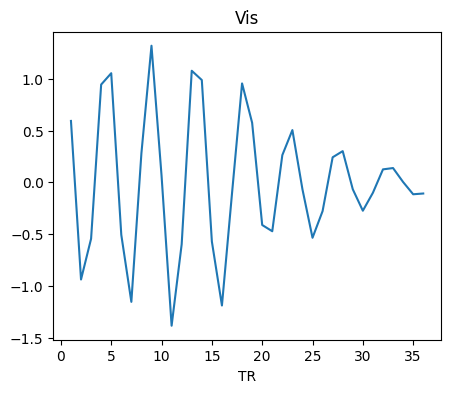

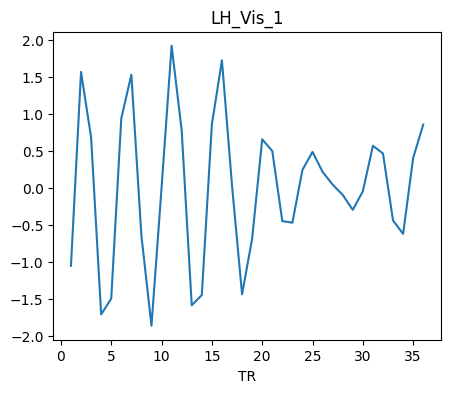

In [3]:
if "AAL" in parcel_approach:
    extractor.visualize_bold(subj_id="01", run="001", region="Precentral", figsize=(5, 4))

    extractor.visualize_bold(subj_id="01", run="001", roi_indx=0, figsize=(5, 4))
else:
    extractor.visualize_bold(subj_id="01", run="001", region="Vis", figsize=(5, 4))

    extractor.visualize_bold(subj_id="01", run="001", roi_indx="LH_Vis_1", figsize=(5, 4))

 <font size="6">Saving Timeseries as Pickle</font>
 
 <font size="3">`self.get_bold` produces a nested dictionary structure containing the subject id, run id, and the associated timeseries data. This nested dictionary is stored in the `self.subject_timeseries` attribute and can be saved as a pickle file using `self.timeseries_to_pickle`.</font>

In [4]:
output_dir = "neurocaps_demo"
extractor.timeseries_to_pickle(output_dir=output_dir, filename="sample_for_neurocaps_demo_timeseries.pkl")

 <font size="6">Co-Activation Patterns (CAPs) With No Groups</font>
 
 <font size="3">Initializing the `CAP` class and using the saved pickle file as input for `self.get_caps`.  When group is `None`, which is the default value of this parameter, then the default group name is "All Subjects".</font>

2025-02-11 15:30:54,290 neurocaps.analysis.cap [INFO] [GROUP: All Subjects | METHOD: davies_bouldin] Optimal cluster size is 4.


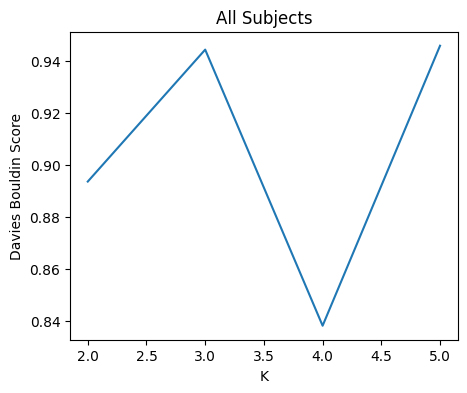

In [5]:
# `parcel_approach` is only required for certain visualization functions and can be set later
# cap_analysis = CAP(parcel_approach = {"Schaefer": {"n_rois": 100}})

cap_analysis = CAP(extractor.parcel_approach, groups=None)

cap_analysis.get_caps(
    subject_timeseries=os.path.join(output_dir, "sample_for_neurocaps_demo_timeseries.pkl"),
    n_clusters=range(2, 6),  # Test k=2 to k=5
    standardize=True,
    cluster_selection_method="davies_bouldin",
    show_figs=True,
    figsize=(5, 4),
)

 <font size="6">Calculating CAP Metrics With No Groups</font>

 <font size="3">Getting CAP metrics using the `self.calculate_metrics` method. Available metrics includes "counts", "temporal_fraction", "persistence", "transition_frequency", and "transition_probability".</font>

In [6]:
# Get metric for the single subject in this `subject_timeseries` pickle file
cap_analysis.calculate_metrics(
    subject_timeseries=os.path.join(output_dir, "sample_for_neurocaps_demo_timeseries.pkl"),
    metrics="persistence",
)["persistence"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3,CAP-4
0,01,All Subjects,run-001,1.4,2.0,1.666667,1.833333


 <font size="6">Co-Activation Patterns (CAPs) With Groups</font>
 
 <font size="3">Performing CAP analysis for two groups using the `groups` parameter when initializing the `CAP` class. Also finding the optimal cluster size for each group by using the elbow method. Additional options for `cluster_selection_method` includes the "silhouette", "davies_bouldin", and "variance_ratio". Additionally, visualizations from any method that produces them can be saved using `output_dir`, all methods have docstrings explaining their purpose, available parameters, kwargs, and properties (in the case of classes). For demonstration purposes, a simulated `subject_timeseries` is created.</font>

2025-02-11 15:30:54,408 neurocaps._utils.check_parcel_approach [WARNING] 'yeo_networks' not specified in `parcel_approach`. Defaulting to 7 networks.
2025-02-11 15:30:54,411 neurocaps._utils.check_parcel_approach [WARNING] 'resolution_mm' not specified in `parcel_approach`. Defaulting to 1mm.


Clustering [GROUP: High ADHD]:   0%|          | 0/23 [00:00<?, ?it/s]

2025-02-11 15:30:58,324 neurocaps.analysis.cap [INFO] [GROUP: High ADHD | METHOD: silhouette] Optimal cluster size is 2.


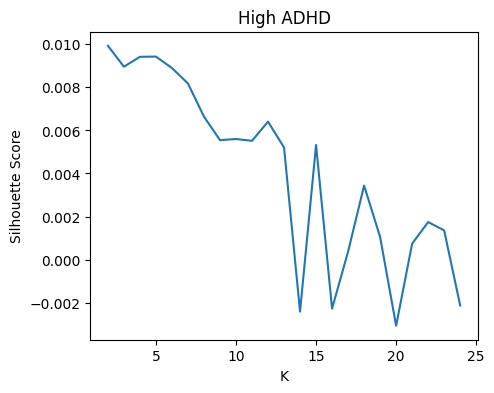

Clustering [GROUP: Low ADHD]:   0%|          | 0/23 [00:00<?, ?it/s]

2025-02-11 15:30:58,642 neurocaps.analysis.cap [INFO] [GROUP: Low ADHD | METHOD: silhouette] Optimal cluster size is 2.


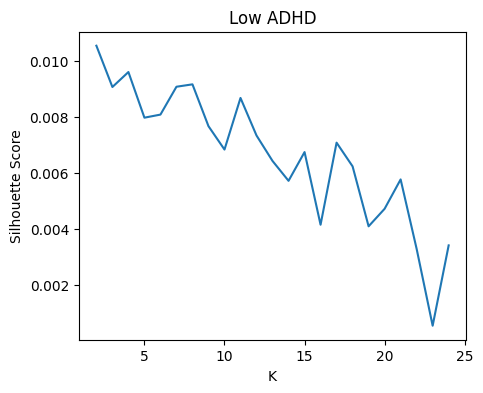

In [7]:
# Simulating a nested dictionary structure containing group data
subject_timeseries = {str(x): {f"run-{y}": np.random.rand(50, ncol) for y in range(1, 4)} for x in range(1, 11)}

# Initializing CAP class and performing the elbow method
cap_analysis = CAP(
    groups={
        "High ADHD": ["1", "2", "3", "5"],
        "Low ADHD": ["4", "6", "7", "8", "9", "10"],
    }
)

# Setting parcel approach instead of assigning it during initialization of the CAP class
cap_analysis.parcel_approach = parcel_approach

cap_analysis.get_caps(
    subject_timeseries=subject_timeseries,
    runs=[1, 2],
    n_clusters=range(2, 25),
    cluster_selection_method="silhouette",
    n_cores=2,  # Used when `n_clusters` is a list, to run multiple kmeans simultaneously
    show_figs=True,
    figsize=(5, 4),
    progress_bar=True,
)

<font size="6">Calculating CAPs Metrics With Groups</font>

 <font size="3">Note, all groups are in the same dataframe for simplicity purposes (except for "transition_probability" where each group has separate dataframes) but use their own kmeans models to calculate each metric. Consequently, "CAP-1" and "CAP-2" are different for each group. In cases where the optimal cluster size for each group differs, values assigned as NaN is just indicates that a group does not have a particular CAP. This done to differentiate it from 0, which indicates a particular CAP did not appear in a subject.</font>

In [8]:
cap_analysis.calculate_metrics(subject_timeseries=subject_timeseries)["temporal_fraction"]

,Subject_ID,Group,Run,CAP-1,CAP-2
0,1,High ADHD,run-1,0.42,0.58
1,1,High ADHD,run-2,0.46,0.54
2,1,High ADHD,run-3,0.50,0.50
3,2,High ADHD,run-1,0.38,0.62
4,2,High ADHD,run-2,0.32,0.68
5,2,High ADHD,run-3,0.38,0.62
6,3,High ADHD,run-1,0.38,0.62
7,3,High ADHD,run-2,0.36,0.64
8,3,High ADHD,run-3,0.48,0.52
9,5,High ADHD,run-1,0.24,0.76


In [9]:
cap_analysis.calculate_metrics(subject_timeseries=subject_timeseries)["counts"]

,Subject_ID,Group,Run,CAP-1,CAP-2
0,1,High ADHD,run-1,14,15
1,1,High ADHD,run-2,11,11
2,1,High ADHD,run-3,15,15
3,2,High ADHD,run-1,14,15
4,2,High ADHD,run-2,11,12
5,2,High ADHD,run-3,11,11
6,3,High ADHD,run-1,13,14
7,3,High ADHD,run-2,11,10
8,3,High ADHD,run-3,12,11
9,5,High ADHD,run-1,9,9


 <font size="6">Calculating CAP Metrics and Treating Separate Runs as Continuous Runs </font>

In [10]:
metrics = cap_analysis.calculate_metrics(
    subject_timeseries=subject_timeseries,
    metrics="transition_probability",
    continuous_runs=True,
)

metrics["transition_probability"]["High ADHD"]

,Subject_ID,Group,Run,1.1,1.2,2.1,2.2
0,1,High ADHD,run-continuous,0.426471,0.573529,0.493827,0.506173
1,2,High ADHD,run-continuous,0.339623,0.660377,0.375000,0.625000
2,3,High ADHD,run-continuous,0.433333,0.566667,0.393258,0.606742
3,5,High ADHD,run-continuous,0.261905,0.738095,0.289720,0.710280


  <font size="6">Transition Probability Matrix</font>
  
 <font size="3">`transition_matrix` can be used to generate and visualize the averaged transition probabilities for each group. </font>

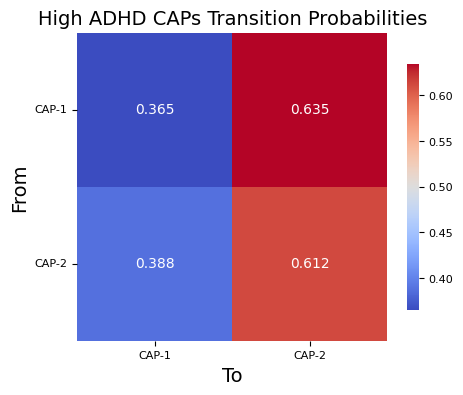

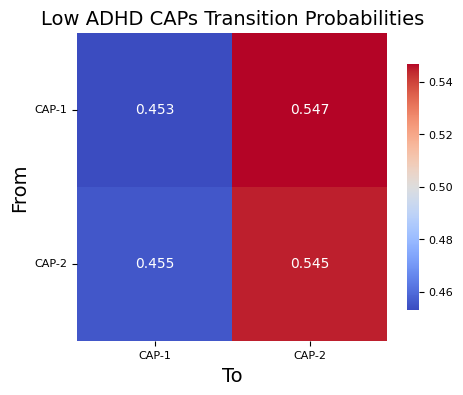

,CAP-1,CAP-2
From/To,,
CAP-1,0.453011,0.546989
CAP-2,0.455314,0.544686


In [11]:
from neurocaps.analysis import transition_matrix

trans_df = transition_matrix(
    trans_dict=metrics["transition_probability"],
    annot=True,
    fmt=".3f",
    return_df=True,
    figsize=(5, 4),
    show_figs=True,
)

trans_df["Low ADHD"]

<font size="6">Plotting CAPs as Outer Products and Heatmaps </font>

 <font size="3">Visualizing CAPs as outer product heatmap at the regional/network level using `self.caps2plot` method.</font>

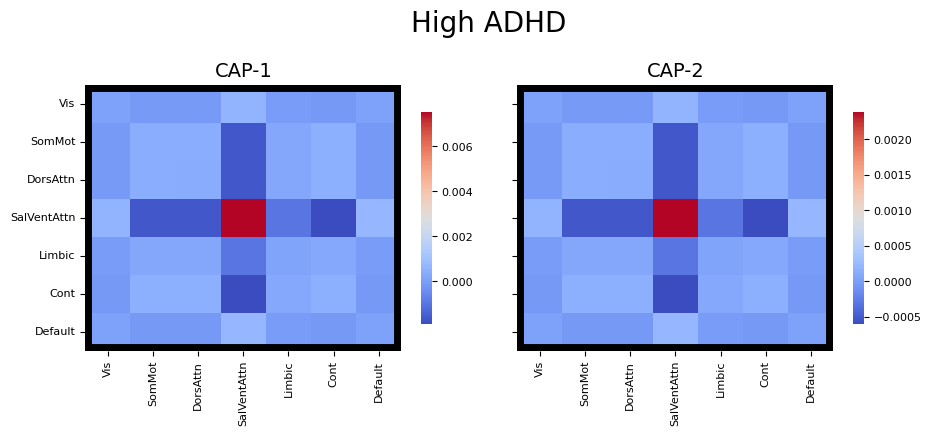

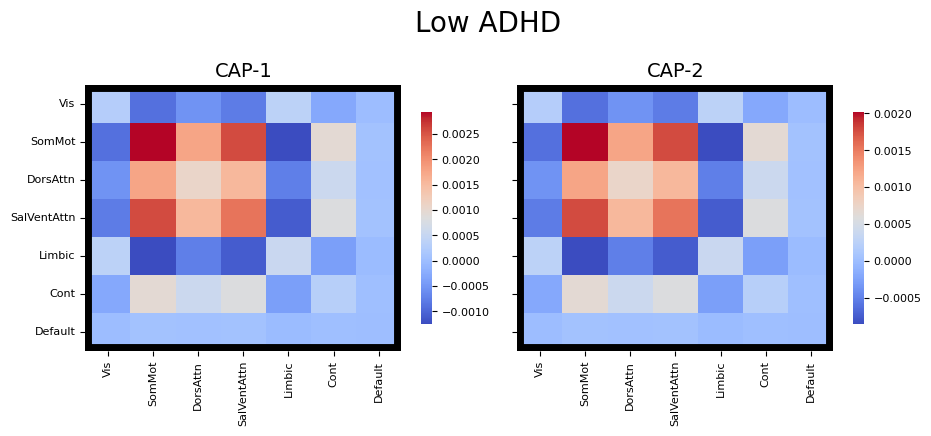

In [12]:
cap_analysis.caps2plot(subplots=True, xlabel_rotation=90, sharey=True, borderwidths=10, figsize=(9, 4))

 <font size="3">Visualizing CAPs as outer product heatmap at the node level using `self.caps2plot` method.</font>

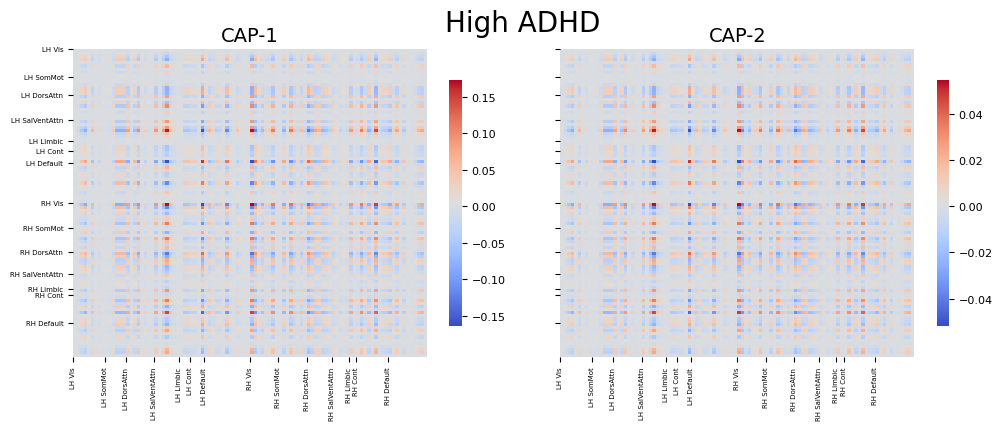

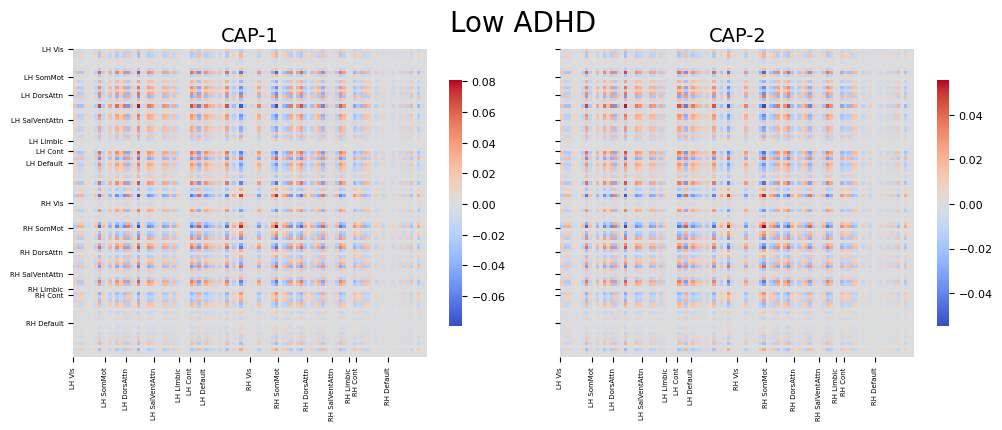

In [13]:
cap_analysis.caps2plot(
    yticklabels_size=5,
    wspace=0.1,
    subplots=True,
    visual_scope="nodes",
    xlabel_rotation=90,
    xticklabels_size=5,
    hspace=0.6,
    tight_layout=False,
    figsize=(12, 4),
)

 <font size="3">Visualizing CAPs as heatmaps at the regional level and using the `hemishere_labels` parameter to label the left and right hemispheres using `self.caps2plot` method.</font>

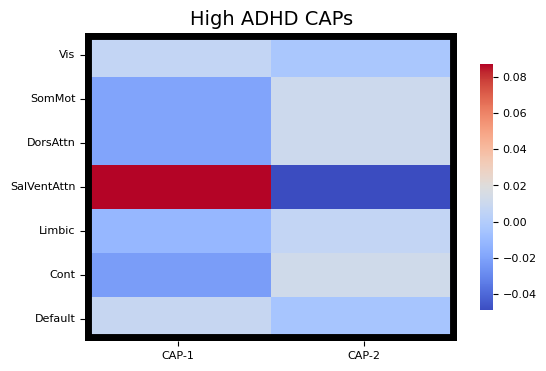

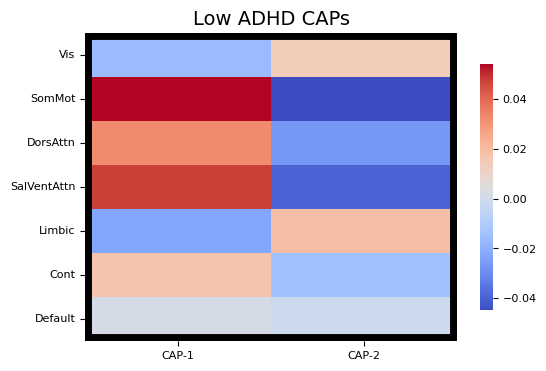

In [14]:
cap_analysis.caps2plot(
    subplots=True,
    visual_scope="regions",
    plot_options="heatmap",
    borderwidths=10,
    figsize=(6, 4),
)

 <font size="6">Merging Different Timeseries Across Sessions or Tasks </font>

 <font size="3">Using `merge_dicts` to merge common subjects across different subject timeseries dictionaries. This is to allow CAPs to be estimated on the merged dictionary (for similar CAPs across tasks or sessions) and for metrics to be calculated for each of the individual dictionaries. For instance, `subject_timeseries_1` may be the extracted timeseries from session 1 and `subject_timeseries_2` are the extracted timeseries for session 2. When merged, only subjects that have at least a single run across sessions will be returned in the merged dictionary. When `return_reduced_dicts` is True, only the subjects in the merged dictionary will be returned for the reduced dictionaries. In this example "dict_0" is the reduced form of `subject_timeseries_1` and "dict_1" is the reduced form of `subject_timeseries_2`. So, "merged" can be used as the input to estimate common CAPs across sessions for `get_caps` and "dict_0" and "dict_1" can be used as inputs for `self.calculate_metrics` to obtain the metrics for the CAPs for each session.</font>

In [15]:
# Simulating two separate `subject_timeseries`
subject_timeseries_1 = {str(x): {f"run-{y}": np.random.rand(100, 400) for y in range(1, 4)} for x in range(1, 11)}
subject_timeseries_2 = {str(x): {f"run-{y}": np.random.rand(100, 400) for y in range(1, 4)} for x in range(1, 7)}

# Returns merged dictionary as well as the reduced subject dictionaries containing only the subjects present in the merged
all_dicts = merge_dicts(
    subject_timeseries_list=[subject_timeseries_1, subject_timeseries_2],
    return_merged_dict=True,
    return_reduced_dicts=True,
)

print(all_dicts["dict_0"].keys())
print(all_dicts["dict_1"].keys())
print(all_dicts["merged"].keys())

dict_keys(['1', '2', '3', '4', '5', '6'])
dict_keys(['1', '2', '3', '4', '5', '6'])
dict_keys(['1', '2', '3', '4', '5', '6'])


 <font size="6">Identifying CAPs in Merged Timeseries </font>

 <font size="3">Generating examples not using the `group` parameter. Note, some additional plotting and non-plotting methods are shown below, all methods in the `CAP` class works regardless if `group` is None or defined since plots are generated for each group. The merged timeseries in `all_dicts` which was generated in the previous cell will be used as input here.</font>

In [16]:
cap_analysis = CAP(parcel_approach={"Schaefer": {"n_rois": 400, "resolution_mm": 1, "yeo_networks": 7}})

cap_analysis.get_caps(subject_timeseries=all_dicts["merged"], n_clusters=3)

 <font size="6">Calculating CAP Metrics on Subsets of Merged Timeseries </font>

In [17]:
output = cap_analysis.calculate_metrics(subject_timeseries=all_dicts["dict_0"], return_df=True, runs=[1, 2])

output["temporal_fraction"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3
0,1,All Subjects,run-1,0.33,0.27,0.40
1,1,All Subjects,run-2,0.32,0.37,0.31
2,2,All Subjects,run-1,0.28,0.35,0.37
3,2,All Subjects,run-2,0.33,0.34,0.33
4,3,All Subjects,run-1,0.25,0.33,0.42
5,3,All Subjects,run-2,0.33,0.31,0.36
6,4,All Subjects,run-1,0.32,0.35,0.33
7,4,All Subjects,run-2,0.25,0.41,0.34
8,5,All Subjects,run-1,0.33,0.37,0.30
9,5,All Subjects,run-2,0.35,0.28,0.37


In [18]:
output = cap_analysis.calculate_metrics(
    subject_timeseries=all_dicts["dict_1"],
    return_df=True,
    runs=[1, 2],
    continuous_runs=True,
)

output["persistence"]

,Subject_ID,Group,Run,CAP-1,CAP-2,CAP-3
0,1,All Subjects,run-continuous,1.521739,1.326531,1.547619
1,2,All Subjects,run-continuous,1.314286,1.461538,1.471698
2,3,All Subjects,run-continuous,1.545455,1.425532,1.413043
3,4,All Subjects,run-continuous,1.425000,1.422222,1.462963
4,5,All Subjects,run-continuous,1.534884,1.476190,1.500000
5,6,All Subjects,run-continuous,1.500000,1.377778,1.604651


In [19]:
output = cap_analysis.calculate_metrics(subject_timeseries=all_dicts["dict_1"], return_df=True, runs=[1, 2])

output["transition_frequency"]

,Subject_ID,Group,Run,Transition_Frequency
0,1,All Subjects,run-1,66
1,1,All Subjects,run-2,69
2,2,All Subjects,run-1,70
3,2,All Subjects,run-2,69
4,3,All Subjects,run-1,69
5,3,All Subjects,run-2,66
6,4,All Subjects,run-1,67
7,4,All Subjects,run-2,70
8,5,All Subjects,run-1,64
9,5,All Subjects,run-2,68


<font size="6">CAPs Pearson Correlation Matrix </font>

 <font size="3">`self.caps2corr` can be used to obtain the Pearson correlation between CAPs and to obtain a dataframe of the uncorrected p-values.</font>

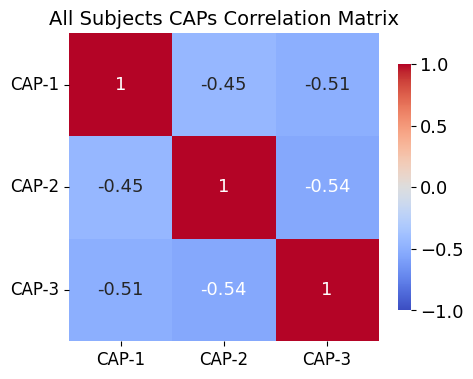

,CAP-1,CAP-2,CAP-3
CAP-1,1 (0)***,-0.45 (1.5e-21)***,-0.51 (1.8e-27)***
CAP-2,-0.45 (1.5e-21)***,1 (0)***,-0.54 (1.3e-31)***
CAP-3,-0.51 (1.8e-27)***,-0.54 (1.3e-31)***,1 (0)***


In [20]:
corr_df = cap_analysis.caps2corr(
    annot=True,
    figsize=(5, 4),
    xticklabels_size=12,
    yticklabels_size=12,
    return_df=True,
    vmin=-1,
    vmax=1,
    annot_kws={"size": 13},
    cbarlabels_size=13,
)

corr_df["All Subjects"]

 <font size="6">CAPs Surface Plots </font> 
 
 <font size="3">Visualizing CAPs as surface plots using `self.caps2surf` method.</font>

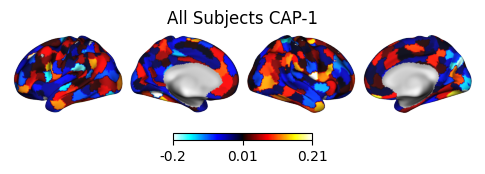

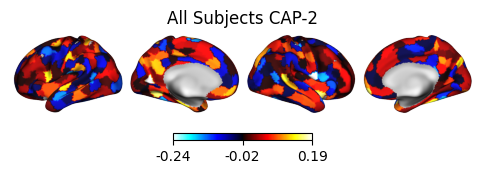

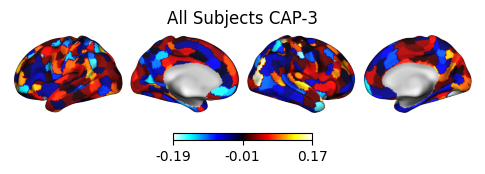

Generating Surface Plots [GROUP: All Subjects]:   0%|          | 0/3 [00:00<?, ?it/s]

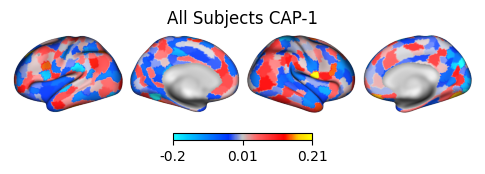

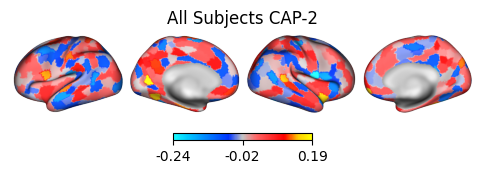

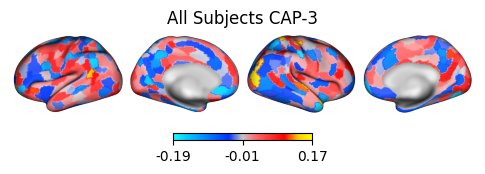

In [21]:
from matplotlib.colors import LinearSegmentedColormap

colors = [
    "#1bfffe",
    "#00ccff",
    "#0099ff",
    "#0066ff",
    "#0033ff",
    "#c4c4c4",
    "#ff6666",
    "#ff3333",
    "#FF0000",
    "#ffcc00",
    "#FFFF00",
]

cap_analysis.caps2surf(cmap="cold_hot", layout="row", size=(500, 100))

# Create the colormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cold_hot", colors, N=256)

cap_analysis.caps2surf(cmap=custom_cmap, size=(500, 100), layout="row", surface="veryinflated", progress_bar=True)

 <font size="6">CAPs to NifTIs </font>

 <font size="3">CAPs can also be projected onto the parcellation and saved as NifTI files. These same files can also be saved when using `self.caps2surf`. Additionally, this function also has the `knn_dict` parameter.</font>

In [22]:
cap_analysis.caps2niftis(output_dir=output_dir, suffix_filename="for_neurocaps_demo", progress_bar=True)

Generating Statistical Maps [GROUP: All Subjects]:   0%|          | 0/3 [00:00<?, ?it/s]

<font size="6">CAPs to Radar Plots </font>

 <font size="3">Radar plots showing the cosine similarity between each network and the positive ("High Amplitude") and negative ("Low Amplitude") activations in each CAP. Since this function assumes that the matrix subjected to kmeans clustering was standardized, "High Amplitude" represents values above the mean (0) and "Low Amplitude" represents values below the mean (0). During calculation of the "Low Amplitude" cosine similarity, the inverse is computed to turn this similarity positive for visualization purposes.</font>

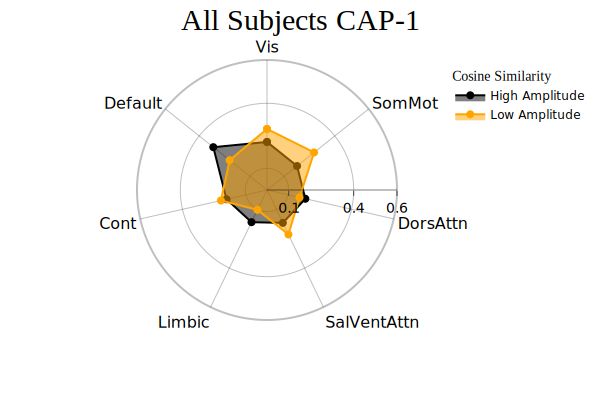

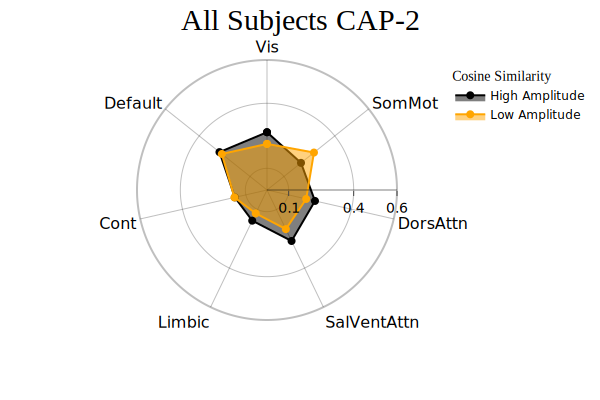

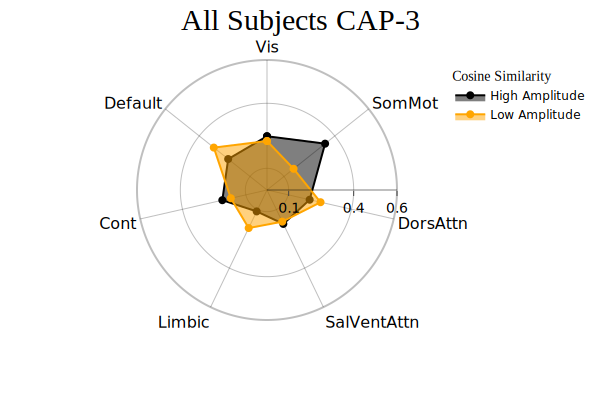

In [23]:
radialaxis = {
    "showline": True,
    "linewidth": 2,
    "linecolor": "rgba(0, 0, 0, 0.25)",
    "gridcolor": "rgba(0, 0, 0, 0.25)",
    "ticks": "outside",
    "tickfont": {"size": 14, "color": "black"},
    "range": [0, 0.6],
    "tickvals": [0.1, "", "", 0.4, "", "", 0.6],
}

legend = {
    "yanchor": "top",
    "y": 0.99,
    "x": 0.99,
    "title_font_family": "Times New Roman",
    "font": {"size": 12, "color": "black"},
}

colors = {"High Amplitude": "black", "Low Amplitude": "orange"}

cap_analysis.caps2radar(
    radialaxis=radialaxis,
    fill="toself",
    height=400,
    width=600,
    color_discrete_map=colors,
    legend=legend,
)

 <font size="3">The cosine similarities are stored in the `self.cosine_similarity` property.</font>

In [24]:
import pandas as pd

df = pd.DataFrame(cap_analysis.cosine_similarity["All Subjects"]["CAP-1"])

df["Regions"] = cap_analysis.cosine_similarity["All Subjects"]["Regions"]

print(df)

   High Amplitude  Low Amplitude      Regions
0        0.221849       0.281732          Vis
1        0.177459       0.277982       SomMot
2        0.181520       0.154106     DorsAttn
3        0.168441       0.227829  SalVentAttn
4        0.164886       0.101898       Limbic
5        0.191681       0.218083         Cont
6        0.317017       0.220559      Default


  <font size="6">Using Custom Parcellations </font>

 <font size="3">The neurocaps package uses nilearn to obtain the "maps" and "nodes" for the Schaefer and AAL atlases, then uses some Python code to create a list of "regions" using the "nodes" list. Neurocaps can also accept additional parcellations (as long as they are lateralized since the current iteration of the codebase assumes an "lh" and "rh" key for each region but this may be changed in a future update. Below is an example using the HCPex atlas from [wayalan Github](https://github.com/wayalan/HCPex/) for the `CAP` class.</font>

In [25]:
import subprocess

# First, retrieve the map and labels from wayalan Github

if sys.platform != "win32":
    cmd = [
        [
            "wget",
            "-q",
            "-P",
            output_dir,
            "https://github.com/wayalan/HCPex/raw/main/HCPex_v1.1/HCPex_LookUpTable.txt",
        ],
        [
            "wget",
            "-q",
            "-P",
            output_dir,
            "https://github.com/wayalan/HCPex/raw/main/HCPex_v1.1/HCPex.nii.gz",
        ],
    ]
else:
    cmd = [
        [
            "curl",
            "-L",
            "-o",
            f"{output_dir}\\HCPex_LookUpTable.txt",
            "https://github.com/wayalan/HCPex/raw/main/HCPex_v1.1/HCPex_LookUpTable.txt",
        ],
        [
            "curl",
            "-L",
            "-o",
            f"{output_dir}\\HCPex.nii.gz",
            "https://github.com/wayalan/HCPex/raw/main/HCPex_v1.1/HCPex.nii.gz",
        ],
    ]

for command in cmd:
    subprocess.run(command, check=True)

# Creating custom parcel approach dictionary
parcel_approach = {"Custom": {}}

# Setting the "maps"; this is needed for `TimeseriesExtractore.get_bold()` and `CAP.caps2niftis` and `CAP.cap2surf`
parcel_approach["Custom"]["maps"] = os.path.join(output_dir, "HCPex.nii.gz")

# Setting the "nodes"; needed for "TimeseriesExtractor.visualize_bold"; Getting nodes that don't correspond to background label
parcel_approach["Custom"]["nodes"] = pd.read_csv(
    os.path.join(output_dir, "HCPex_LookUpTable.txt"),
    sep=None,
    engine="python",
)["Label"].values[1:]

# Needed for many plotting methods; Setting the region names and their corresponding indices in the nodes list, in this case it is just the label id - 1
parcel_approach["Custom"]["regions"] = {
    "Primary Visual": {"lh": [0], "rh": [180]},
    "Early Visual": {"lh": [1, 2, 3], "rh": [181, 182, 183]},
    "Dorsal Stream Visual": {"lh": range(4, 10), "rh": range(184, 190)},
    "Ventral Stream Visual": {"lh": range(10, 17), "rh": range(190, 197)},
    "MT+ Complex": {"lh": range(17, 26), "rh": range(197, 206)},
    "SomaSens Motor": {"lh": range(26, 31), "rh": range(206, 211)},
    "ParaCentral MidCing": {"lh": range(31, 40), "rh": range(211, 220)},
    "Premotor": {"lh": range(40, 47), "rh": range(220, 227)},
    "Posterior Opercular": {"lh": range(47, 52), "rh": range(227, 232)},
    "Early Auditory": {"lh": range(52, 59), "rh": range(232, 239)},
    "Auditory Association": {"lh": range(59, 67), "rh": range(239, 247)},
    "Insula FrontalOperc": {"lh": range(67, 79), "rh": range(247, 259)},
    "Medial Temporal": {"lh": range(79, 87), "rh": range(259, 267)},
    "Lateral Temporal": {"lh": range(87, 95), "rh": range(267, 275)},
    "TPO": {"lh": range(95, 100), "rh": range(275, 280)},
    "Superior Parietal": {"lh": range(100, 110), "rh": range(280, 290)},
    "Inferior Parietal": {"lh": range(110, 120), "rh": range(290, 300)},
    "Posterior Cingulate": {"lh": range(120, 133), "rh": range(300, 313)},
    "AntCing MedPFC": {"lh": range(133, 149), "rh": range(313, 329)},
    "OrbPolaFrontal": {"lh": range(149, 158), "rh": range(329, 338)},
    "Inferior Frontal": {"lh": range(158, 167), "rh": range(338, 347)},
    "Dorsolateral Prefrontal": {"lh": range(167, 180), "rh": range(347, 360)},
    "Subcortical Regions": {"lh": range(360, 393), "rh": range(393, 426)},
}

# Saving the dictionary as a pickle file
with open(os.path.join(output_dir, "HCPex_dict.pkl"), "wb") as f:
    joblib.dump(parcel_approach, f)

<font size="3">For "Custom" parcel approaches, all visualization methods can be used.

In [26]:
# Creating new subject timeseries that has 426 columns
subject_timeseries = {str(x): {f"run-{y}": np.random.rand(50, 426) for y in range(1, 4)} for x in range(1, 11)}

cap_analysis = CAP(parcel_approach=os.path.join(output_dir, "HCPex_dict.pkl"))

cap_analysis.get_caps(
    subject_timeseries=subject_timeseries,
    cluster_selection_method="variance_ratio",
    n_clusters=range(2, 11),
)

# The `parcel_approach`` can be set using the dictionary format when initializing the `CAP`` class or using the `parcel_approach`` property as a setter
# cap_analysis.parcel_approach = parcel_approach
# cap_analysis.parcel_approach = os.path.join(output_dir, "neurocaps_demo", "HCPex_dict.pkl")

2025-02-11 15:31:57,741 neurocaps.analysis.cap [INFO] [GROUP: All Subjects | METHOD: variance_ratio] Optimal cluster size is 2.


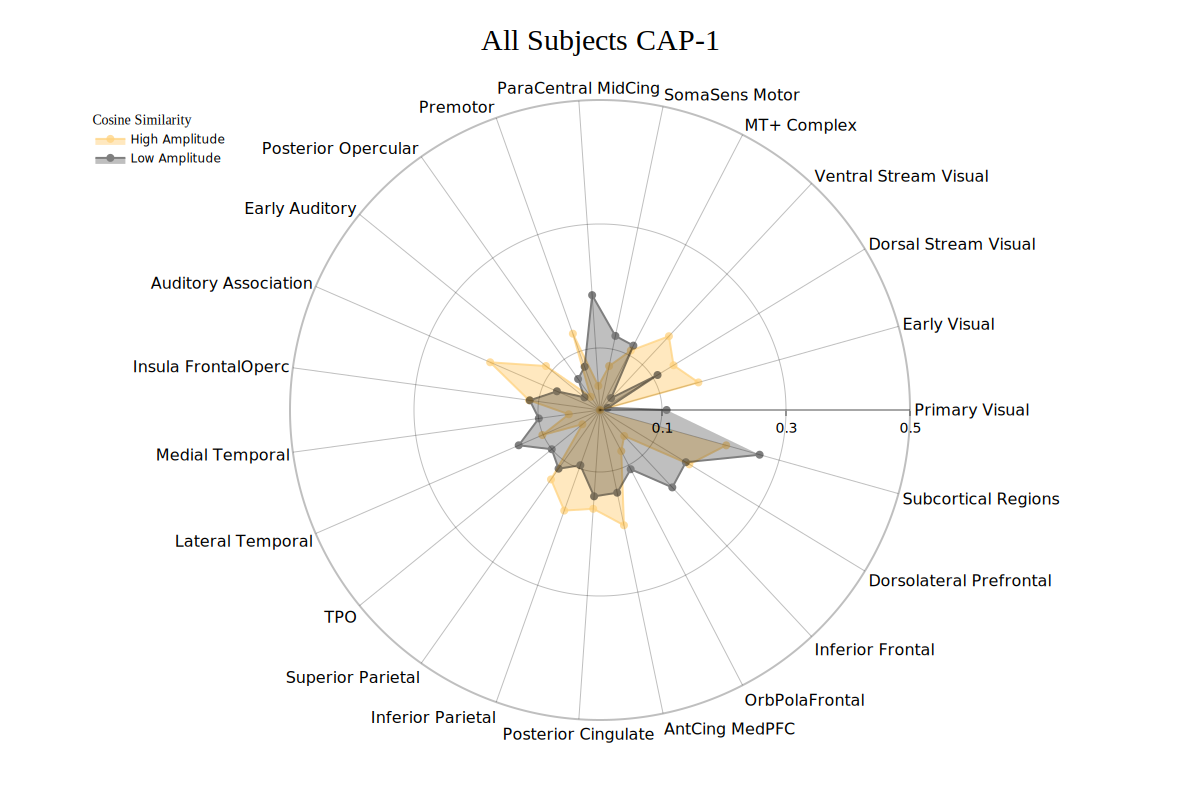

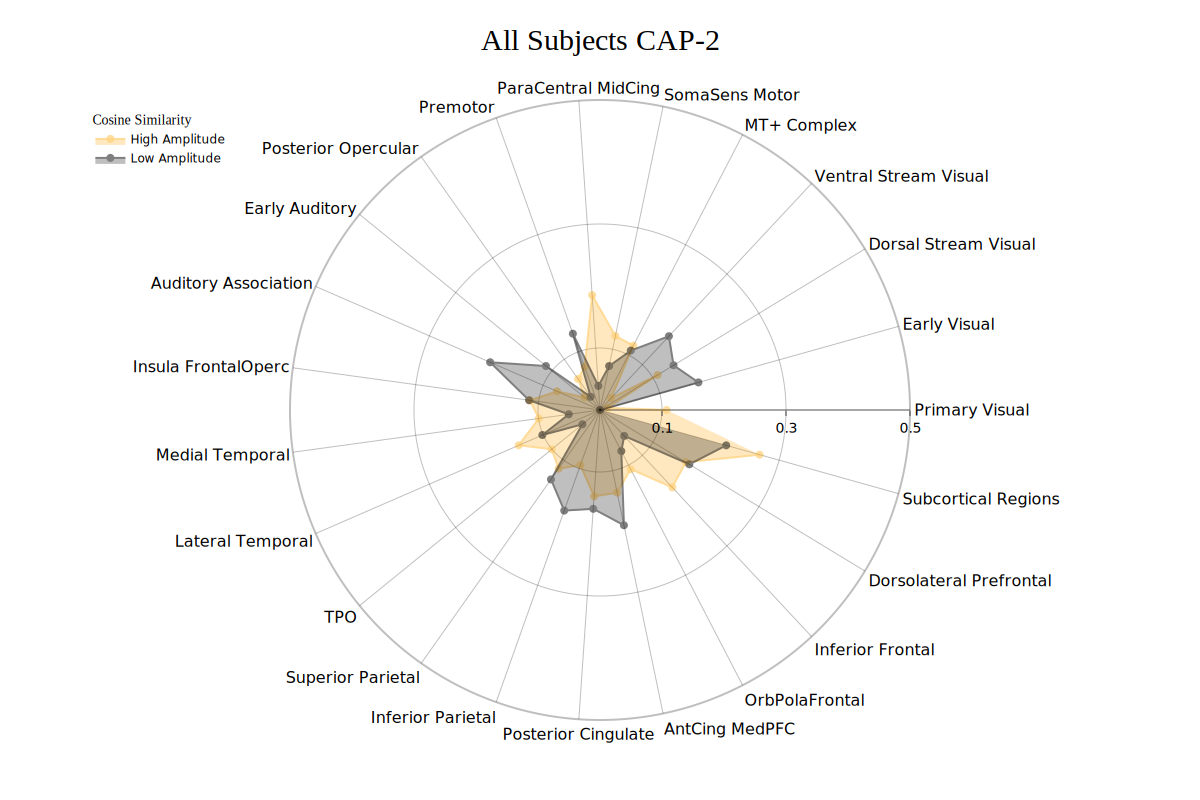

In [27]:
radialaxis = {
    "showline": True,
    "linewidth": 2,
    "linecolor": "rgba(0, 0, 0, 0.25)",
    "gridcolor": "rgba(0, 0, 0, 0.25)",
    "ticks": "outside",
    "tickfont": {"size": 14, "color": "black"},
    "range": [0, 0.5],
    "tickvals": [0.1, "", 0.3, "", 0.5],
}

color_discrete_map = {
    "High Amplitude": "rgba(255, 165, 0, 0.75)",
    "Low Amplitude": "black",
}

cap_analysis.caps2radar(
    radialaxis=radialaxis,
    fill="toself",
    color_discrete_map=color_discrete_map,
    use_scatterpolar=True,
    output_dir=output_dir,
    as_html=True,
)

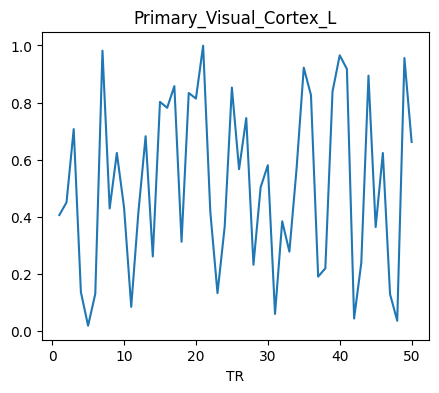

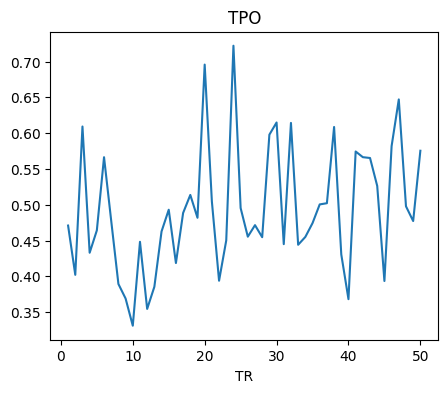

In [28]:
extractor.parcel_approach = os.path.join(output_dir, "HCPex_dict.pkl")

# Can also just set it
# extractor = TimeseriesExtractor(parcel_approach=os.path.join(output_dir,"neurocaps_demo", "HCPex_dict.pkl"))

# Subject timeseries also acts as a setter if the `visualize_bold` method needs to be used
extractor.subject_timeseries = subject_timeseries

with open(os.path.join(output_dir, "sample_for_neurocaps_demo_timeseries_HCPex.pkl"), "wb") as f:
    joblib.dump(subject_timeseries, f)

extractor.subject_timeseries = os.path.join(output_dir, "sample_for_neurocaps_demo_timeseries_HCPex.pkl")

extractor.visualize_bold(
    subj_id="1",
    run=1,
    roi_indx=0,
    figsize=(5, 4),
    output_dir=output_dir,
    filename="test_bold_for_neurocaps",
)

extractor.visualize_bold(subj_id="1", run=1, region="TPO", figsize=(5, 4))

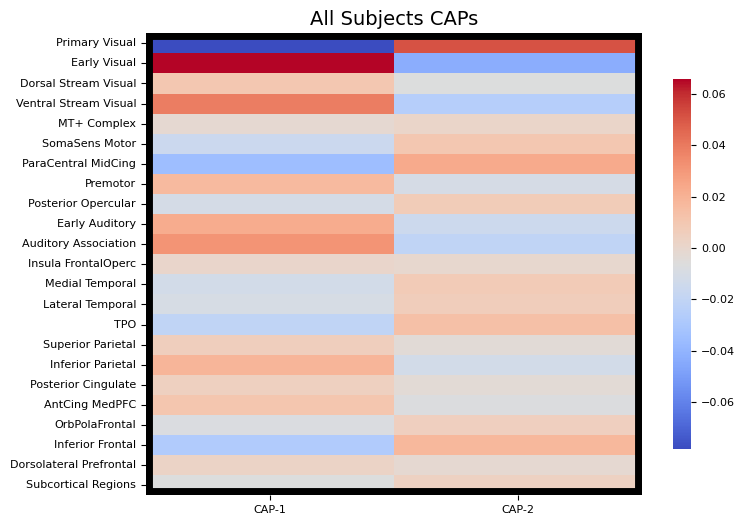

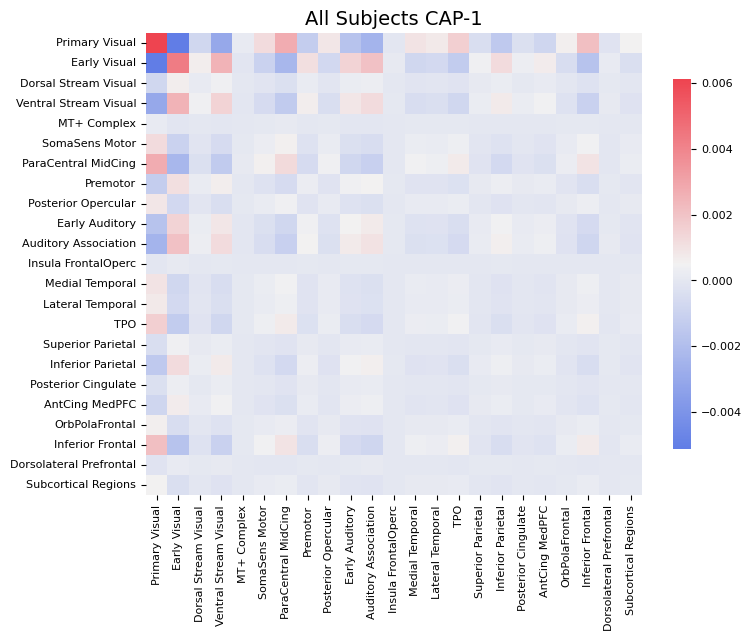

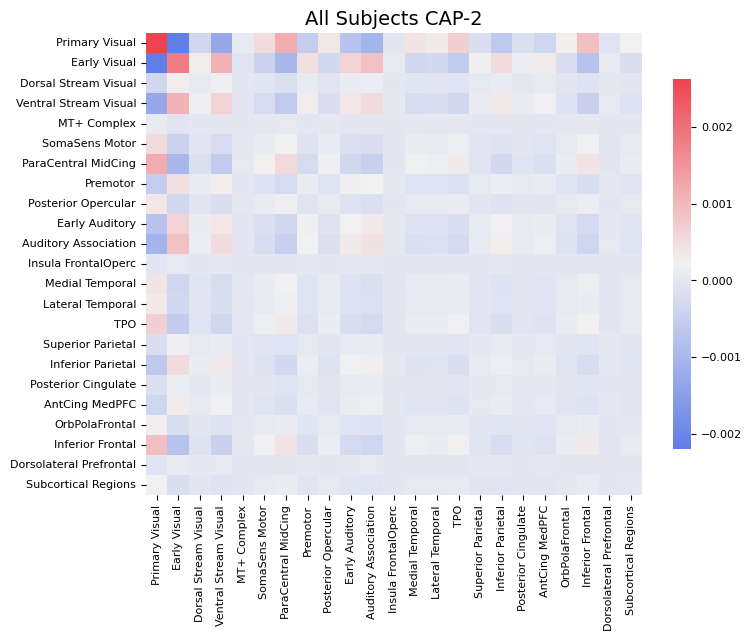

In [29]:
import seaborn as sns

sns.diverging_palette(145, 300, s=60, as_cmap=True)

palette = sns.diverging_palette(260, 10, s=80, l=55, n=256, as_cmap=True)

cap_analysis.caps2plot(visual_scope="regions", plot_options="heatmap", borderwidths=10)

cap_analysis.caps2plot(
    visual_scope="regions",
    plot_options="outer_product",
    subplots=False,
    fontsize=14,
    tight_layout=False,
    xlabel_rotation=90,
    hspace=0.3,
    cmap=palette,
    output_dir=output_dir,
)

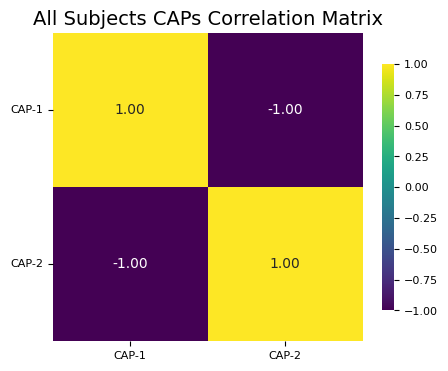

,Subject_ID,Group,Run,CAP-1,CAP-2
0,1,All Subjects,run-continuous,3.666667,4.540541
1,2,All Subjects,run-continuous,3.487179,4.315789
2,3,All Subjects,run-continuous,3.500000,5.875000
3,4,All Subjects,run-continuous,3.219512,4.200000
4,5,All Subjects,run-continuous,3.314286,5.257143
5,6,All Subjects,run-continuous,3.172414,7.172414
6,7,All Subjects,run-continuous,3.454545,5.636364
7,8,All Subjects,run-continuous,3.200000,5.371429
8,9,All Subjects,run-continuous,3.600000,4.833333
9,10,All Subjects,run-continuous,2.850000,4.650000


In [30]:
cap_analysis.caps2corr(annot=True, cmap="viridis", fmt=".2f", figsize=(5, 4), output_dir=output_dir)

outputs = cap_analysis.calculate_metrics(
    subject_timeseries=os.path.join(output_dir, "sample_for_neurocaps_demo_timeseries_HCPex.pkl"),
    tr=2,
    continuous_runs=True,
    metrics=["persistence", "transition_probability"],
    output_dir=output_dir,
)

outputs["persistence"]

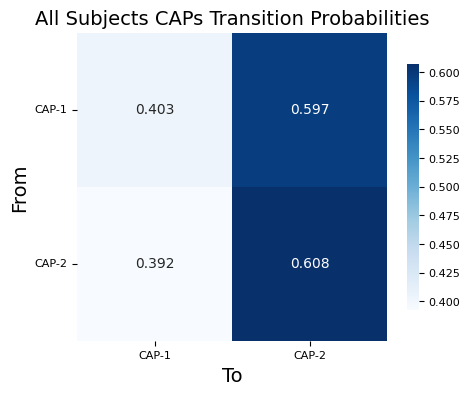

,CAP-1,CAP-2
From/To,,
CAP-1,0.403493,0.596507
CAP-2,0.392402,0.607598


In [31]:
trans_df = transition_matrix(
    trans_dict=outputs["transition_probability"],
    annot=True,
    fmt=".3f",
    return_df=True,
    figsize=(5, 4),
    cmap="Blues",
)

trans_df["All Subjects"]

<font size="6">Using KNN to Fix Surface Plot Visualization Issues </font>

<font size="3">This is primarily for parcellations outside of Schaefer and AAL. If you notice that your surface plots are sparse due to having many unassigned cortical surface voxels, there is a `knn_dict` parameter in both `self.caps2surf` and `self.caps2niftis`, which uses the Schaefer atlas as a reference atlas to determine the background boundaries so that k-nearest neighbors interpolation can be used. The sub-keys are "k" and "resolution_mm" for the resolution of Schaefer to use as the reference. **This process may take a few minutes depending on your computer**.</font>

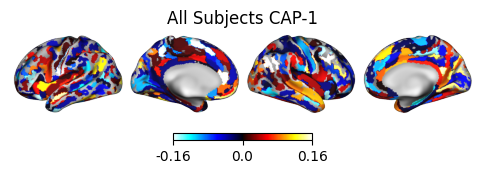

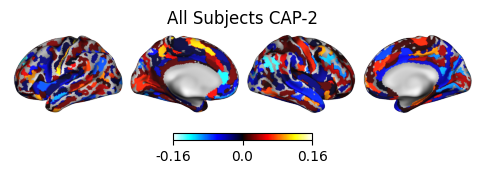

2025-02-11 15:32:14,259 neurocaps.analysis.cap [WARNING] 'reference_atlas' not specified in `knn_dict`. The default reference atlas is 'Schaefer'.
2025-02-11 15:32:14,260 neurocaps.analysis.cap [WARNING] Defaulting to 1mm resolution for the Schaefer atlas since 'resolution_mm' was not specified in `knn_dict`.


Generating Surface Plots [GROUP: All Subjects]:   0%|          | 0/2 [00:00<?, ?it/s]

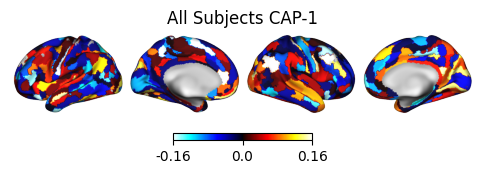

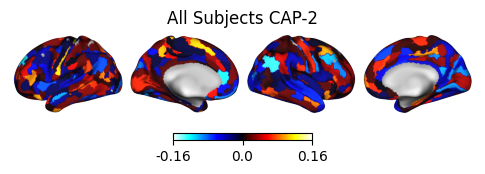

In [32]:
# Plotting with caps2surf; showing original and version using knn to reduce gaps
cap_analysis.caps2surf(size=(500, 100), layout="row", method="nearest", color_range=[-0.16, 0.16])

cap_analysis.caps2surf(
    size=(500, 100),
    layout="row",
    method="nearest",
    knn_dict={"k": 5},
    color_range=[-0.16, 0.16],
    save_stat_maps=True,
    output_dir=output_dir,
    progress_bar=True,
)

 <font size="3">Removes the files and directories generated in this demo.</font>

In [33]:
import shutil

shutil.rmtree("neurocaps_demo", ignore_errors=True)